# Titanic: Machine Learning from Disaster

## The Data
* Survival - Survival
* pclass - Ticket class 
* sex - Sex
* Age - Age in years
* sibsp - # of siblings / spouses aboard the Titanic
* parch - # of parents / children aboard the Titanic
* ticket - Ticket number
* fare - Passenger fare
* cabin - Cabin number
* embarked - Port of Embarkation

**Variable Notes**

* pclass: A proxy for socio-economic status (SES)
    * 1st = Upper
    * 2nd = Middle
    * 3rd = Lower

* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* sibsp: The dataset defines family relations in this way...
    * Sibling = brother, sister, stepbrother, stepsister
    * Spouse = husband, wife (mistresses and fiancés were ignored)

* parch: The dataset defines family relations in this way...
    * Parent = mother, father
    * Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

%matplotlib inline

Let's take an initial look at the data by combining the training and test set.

In [2]:
train = pd.read_csv('train.csv', dtype={'Age': np.float64})
test = pd.read_csv('test.csv', dtype={'Age': np.float64})
testID = test['PassengerId']
titanic = train.append(test, ignore_index=True)

In [3]:
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [5]:
titanic.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


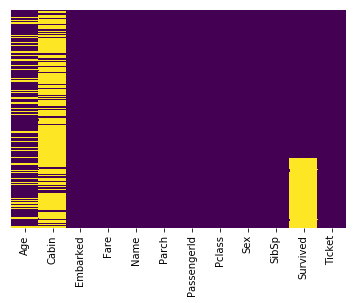

In [6]:
sns.heatmap(titanic.isnull(), yticklabels=False, cbar=False, cmap='viridis')

An initial look at the data shows that `Age`, `Cabin`, `Embarked`, `Fare` are missing values. The null values in `Survived` come from the test set, so we do not need to worry about it.

# Title

First let's make a title feature by extracting the title from `Name`.  This is a necessary initial step before we can process age.

In [7]:
titanic['Title'] = titanic['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))

titanic.groupby(['Title', 'Sex'])['Survived'].mean()

Title     Sex   
Capt      male      0.000000
Col       male      0.500000
Countess  female    1.000000
Don       male      0.000000
Dona      female         NaN
Dr        female    1.000000
          male      0.333333
Jonkheer  male      0.000000
Lady      female    1.000000
Major     male      0.500000
Master    male      0.575000
Miss      female    0.697802
Mlle      female    1.000000
Mme       female    1.000000
Mr        male      0.156673
Mrs       female    0.792000
Ms        female    1.000000
Rev       male      0.000000
Sir       male      1.000000
Name: Survived, dtype: float64

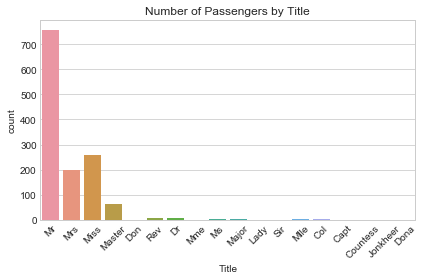

In [8]:
sns.set_style('whitegrid')
sns.countplot(titanic['Title']);
plt.xticks(rotation=45)
plt.title('Number of Passengers by Title')
plt.tight_layout()

Grouping the dataset by `Title` and `Sex` shows that females are more likely to survive than males.  It can also be seen that the four most common titles are Mr, Mrs, Miss, and Master.  Let's group the rest of the titles together into the four most common titles.

In [9]:
def changeTitle(data):
    title = data['Title']
    if title in set(['Capt', 'Col', 'Major', 'Sir', 'Jonkheer', 'Don', 'Rev']):
        return 'Mr'
    elif title in set(['Mme', 'Dona', 'Lady', 'Countess']):
        return 'Mrs'
    elif title in set(['Mlle', 'Ms']):
        return 'Miss'
    elif title == 'Dr':
        if data['Sex'] == 'male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
titanic['Title'] = titanic.apply(changeTitle, axis=1)

# Age


Now that we have dealt with title, we can replace the null values in Age with the median values sorted by `Sex`, `Pclass`, and `Title`.

In [10]:
titanic.groupby(['Sex','Pclass','Title'])['Age'].median()

Sex     Pclass  Title 
female  1       Miss      30.0
                Mrs       45.0
        2       Miss      20.0
                Mrs       30.5
        3       Miss      18.0
                Mrs       31.0
male    1       Master     6.0
                Mr        42.0
        2       Master     2.0
                Mr        30.0
        3       Master     6.0
                Mr        26.0
Name: Age, dtype: float64

In [11]:
titanic['Age'] = titanic.groupby(['Sex','Pclass','Title'])['Age'].apply(lambda x: x.fillna(x.median()))

# Fare

Let's impute the singular Fare value.  Note: I got better results on my model using mean over median.

In [12]:
titanic['Fare'].fillna(titanic['Fare'].mean(), inplace=True)

# Sex

Let's preprocess `Sex`

In [13]:
titanic['Sex'] = LabelEncoder().fit_transform(titanic['Sex'])

# Family Size

As mentioned above, sibsp refers to the number of spouses aboard the Titanic parch represents the number of parents/children aboard the Titanic.  So it makes sense to combine the two into a family size column.

In [14]:
titanic['Family_Size'] = titanic['SibSp'] + titanic['Parch']

In [15]:
titanic.groupby('Family_Size')['Survived'].mean()

Family_Size
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

# Family Survival

This is a feature originally found on this <a href='https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever'>kernel</a>.

This feature basically looks to see if the passenger has any surviving family members by parsing through identical Last Names, Fare prices, and Ticket number.  Any unknown values are set to 0.5 by default.  A passenger with a surviving family member will get a 1, and a passenger with no surviving family members will get a 0.

In [16]:
titanic['Last_Name'] = titanic['Name'].apply(lambda x: str.split(x, ",")[0])

In [17]:
titanic.groupby(['Last_Name', 'Fare'])['Survived'].count().head()

Last_Name    Fare  
Abbing       7.550     1
Abbott       20.250    2
Abelseth     7.650     0
Abelson      24.000    2
Abrahamsson  7.925     0
Name: Survived, dtype: int64

In [18]:
titanic.groupby(['Ticket', 'Fare'])['Survived'].count().head()

Ticket  Fare 
110152  86.50    3
110413  79.65    3
110465  52.00    2
110469  26.00    0
110489  26.55    0
Name: Survived, dtype: int64

We can see that familys all pay the same fare price and also that there are groups of people with the same ticket number pay the same fare price.  This is valuable information as it is indicative of those who are wealthier or poorer.

In [19]:
DEFAULT_SURVIVAL_VALUE = 0.5
titanic['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in titanic.groupby(['Last_Name', 'Fare']):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                titanic.loc[titanic['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                titanic.loc[titanic['PassengerId'] == passID, 'Family_Survival'] = 0

for _, grp_df in titanic.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival'] == 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    titanic.loc[titanic['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin == 0.0):
                    titanic.loc[titanic['PassengerId'] == passID, 'Family_Survival'] = 0

In [20]:
print("Number of passenger with family/group survival information: {}"\
      .format(titanic[titanic['Family_Survival'] != 0.5].shape[0])) 

Number of passenger with family/group survival information: 546


# Bins for Fare and Age

Initially, I tried treating `Age` and `Fare` as numerical variables, but found that I got better results treating `Fare` and `Age` as ordinal variables.

In [21]:
titanic['FareBin'] = pd.qcut(titanic['Fare'], 5)
titanic['FareBin_Num'] = LabelEncoder().fit_transform(titanic['FareBin'])
titanic.drop(['Fare', 'FareBin'], axis=1, inplace=True)

In [22]:
titanic['AgeBin'] = pd.qcut(titanic['Age'], 4)
titanic['AgeBin_Num'] = LabelEncoder().fit_transform(titanic['AgeBin'])
titanic.drop('AgeBin', axis=1, inplace=True)

# Women in Pclass 3

In [23]:
titanic.groupby(['Sex', 'Pclass'])['Survived'].mean()

Sex  Pclass
0    1         0.968085
     2         0.921053
     3         0.500000
1    1         0.368852
     2         0.157407
     3         0.135447
Name: Survived, dtype: float64

Another feature I decided to include was the inclusion of third class women because I found this group to be the most problematic in my model.  If a woman was in a higher class, she was much more likely to have survived.  

Note: Sex 0 refers to women and Sex 1 refers to men.

In [24]:
def third_class_woman(data):
    return (data['Pclass'] == 3 and data['Sex'] == 0)

titanic['Third_Class_Woman'] = titanic.apply(third_class_woman, axis=1)

# Preprocessing

I tried a lot of different types of feature engineering with some of the existing features, but none of which really helped my score. I tried using ticket prefixes, maiden_names, children, embarked,or even ordinally using cabins, but they all made my score worse.  Because of that I decided to drop those features out of my model.  In addition, I drop other useless or highly correlated features such as Name, SibSp, Parch, etc.

In [25]:
#titanic['Pclass'] = titanic['Pclass'].astype('category')
drop_list = ['PassengerId', 'Age', 'Name', 'Ticket', 'SibSp', 'Parch', 'Embarked', 'Last_Name', 'Cabin', 'Embarked', 'Title']

titanic_processed = titanic.drop(drop_list, axis=1)
#titanic_processed['Title'] = pd.get_dummies(titanic_processed['Title'], drop_first=True)

In [27]:
titanic_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
Pclass               1309 non-null int64
Sex                  1309 non-null int64
Survived             891 non-null float64
Family_Size          1309 non-null int64
Family_Survival      1309 non-null float64
FareBin_Num          1309 non-null int64
AgeBin_Num           1309 non-null int64
Third_Class_Woman    1309 non-null bool
dtypes: bool(1), float64(2), int64(5)
memory usage: 72.9 KB


Standardization is our friend.

In [28]:
columns = titanic_processed.drop('Survived', axis=1).columns
standard_scale = StandardScaler()
titanic_processed[columns] = standard_scale.fit_transform(titanic_processed[columns])

In [29]:
titanic_processed.head()

,Pclass,Sex,Survived,Family_Size,Family_Survival,FareBin_Num,AgeBin_Num,Third_Class_Woman
0,0.841916,0.743497,0.0,0.073352,-0.071151,-1.392618,-0.419212,-0.444546
1,-1.546098,-1.344995,1.0,0.073352,-0.071151,1.417304,1.348095,-0.444546
2,0.841916,-1.344995,1.0,-0.558346,-0.071151,-0.690137,-0.419212,2.249486
3,-1.546098,-1.344995,1.0,0.073352,-1.623431,1.417304,0.464441,-0.444546
4,0.841916,0.743497,0.0,-0.558346,-0.071151,-0.690137,0.464441,-0.444546


In [30]:
train = titanic_processed[0:891]
test_copy = titanic_processed[891:]

In [31]:
X = train.drop(['Survived'], axis=1)
y = train['Survived']

test_copy = test_copy.drop(['Survived'], axis=1)

# Modeling

Surprisingly, KNN gave me the best overall score on the test set.  I tried other models such as Logistic Regression, Random Forest, SVM, Gradient Boosting.  These models were giving me an accuracy ranging from 78-82%. I could be missing some optimal parameters for those algorithms though.

In [34]:
n_neighbors = [6, 7, 8, 10, 12, 16, 20, 22]
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))

param_grid = { 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring="accuracy", verbose=1)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
0.848484848485
KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=22, p=2,
           weights='uniform')


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:   16.9s finished


# Submission

In [30]:
y_pred = grid.best_estimator_.predict(test_copy)

In [31]:
submit = pd.DataFrame({ 'PassengerId': testID,
                        'Survived': y_pred }, 
                          dtype='int64')

submit.to_csv("submit.csv", index=False)

## Future Things To Improve On

* Ensembling different models together with different weights
* Feature Importance
* Neural Networks
* Feature Engineering

![Placement](Titanic_Competition.png)